# Parameter inference

Let's start by importing the necessary packages:

In [74]:
import scipy


In [ ]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np

import pyabc

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

## Problem definition

Our model is about as simple as it gets. We assume a Gaussian model $\mathcal{N}(\mu, 0.5^2)$ with a single parameter $\mu$ and fixed variance $0.5^2$.

In [2]:
def model(parameter):
    return {"data": parameter["mu"] + 0.5 * np.random.randn()}

In [64]:
prior = pyabc.Distribution(mu=pyabc.RV("norm", 2, 1))

<div class="alert alert-warning">
Note: A common mistake is that the scipy uniform distribution takes arguments `lower_bound, width`, the second argument not being the upper bound. For example, `RV("uniform", 1, 5)` is uniform over the interval $[1,6]$. Check the `scipy.stats` package for details of the definition.
</div>

We also need to specify a distance function, measuring closeness of simulated and observed data.
We just take the absolute value of the difference here.

In [65]:
def distance(x, x0):
    return abs(x["data"] - x0["data"])

## ABC inference

In [66]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [67]:
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = 2.5
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.History INFO: Start <ABCSMC id=7, start_time=2025-10-07 16:54:54>


Let's start the sampling now. We'll sample until the acceptance threshold epsilon drops below 0.1. We also specify that we want a maximum number of 10 populations.
So whatever is reached first, `minimum_epsilon` or `max_nr_populations`, will stop further sampling.

The acceptance thresholds are automatically calibrated and updated. This and further components such as proposal kernels and parallelization strategy (on Linux, per default multi-processing) can be modified via arguments to the ``ABCSMC` class, see the API documentation or further examples.

For the simple model we defined above, this should only take a couple of seconds:

In [88]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)

ABC INFO: t: 17, eps: 7.59141274e-01.
ABC INFO: Accepted: 1000 / 1298 = 7.7042e-01, ESS: 3.7043e+02.
ABC INFO: t: 18, eps: 3.67575118e-01.
ABC INFO: Accepted: 1000 / 2764 = 3.6179e-01, ESS: 9.3674e+02.
ABC INFO: t: 19, eps: 1.85411876e-01.
ABC INFO: Accepted: 1000 / 4857 = 2.0589e-01, ESS: 8.2025e+02.
ABC INFO: t: 20, eps: 9.24449884e-02.
ABC INFO: Accepted: 1000 / 9189 = 1.0883e-01, ESS: 7.4394e+02.
ABC INFO: t: 21, eps: 4.56630679e-02.
ABC INFO: Accepted: 1000 / 19110 = 5.2329e-02, ESS: 7.6186e+02.
ABC INFO: t: 22, eps: 2.23720741e-02.
ABC INFO: Accepted: 1000 / 39963 = 2.5023e-02, ESS: 7.6772e+02.
ABC INFO: t: 23, eps: 1.06501880e-02.
ABC INFO: Accepted: 1000 / 83216 = 1.2017e-02, ESS: 7.0971e+02.
ABC INFO: t: 24, eps: 5.18078746e-03.
ABC INFO: Accepted: 1000 / 163845 = 6.1033e-03, ESS: 8.4970e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=7, duration=0:27:09.205910, end_time=2025-10-07 17:22:03>


The `History` object returned by `ABCSMC.run` can be used to query the database.
This object is also available via `abc.History("sqlite:///" + db_path)`.

## Visualization and analysis of results

Now, we can visualize the obtained Bayesian posterior approximation.
The vertical line indicates the location of the observation, while the curves give the ABC posterior at different generations (usually, only the last one is of interest).
Given our model, we expect the mean to be close to the observed data, with some uncertainty. For more-dimensional parameter vectors, pyABC also offers `plot_kde_2d` and `plot_kde_matrix` plots.

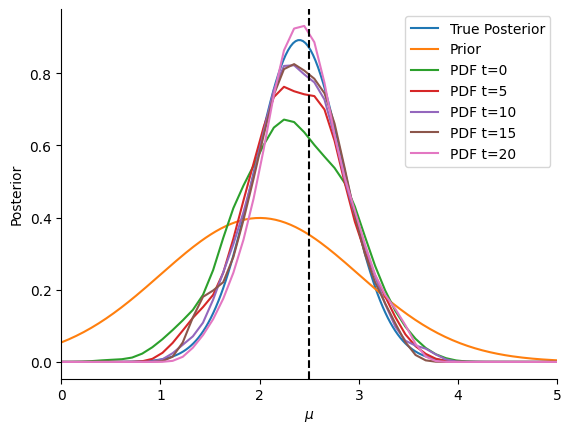

In [ ]:
fig, ax = plt.subplots()
# Plot true analytical posterior
ax.plot(np.linspace(0,5,200), scipy.stats.norm.pdf(np.linspace(0,5,200), (4*observation+2)/5, np.sqrt(1/5)), label="True Posterior")
# Plot prior
ax.plot(np.linspace(0,5,200), scipy.stats.norm.pdf(np.linspace(0,5,200), 2, 1), label="Prior")
for t in np.arange(0, history.max_t + 1, 5, dtype=int):
    df, w = history.get_distribution(m=0, t=t)
    # Plots the Kernel Density Estimate (KDE) using the SMC-ABC samples and their weights. Mathematically, we must 
    # weight the samples using their SMC importance weights when calculating density estimates and expectations 
    # since it is the WEIGHTED versions that converge to the true posterior in the limit. 
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=5,
        x="mu",
        xname=r"$\mu$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(observation, color="k", linestyle="dashed")
ax.legend();

/Users/Lieve/Documents/Masters Project/abc_venv/lib/python3.9/site-packages/pyabc/visualization/epsilon.py:85: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()
/Users/Lieve/Documents/Masters Project/abc_venv/lib/python3.9/site-packages/pyabc/visualization/effective_sample_size.py:96: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


<Axes: title={'center': 'Effective sample size'}, xlabel='Population index', ylabel='ESS'>

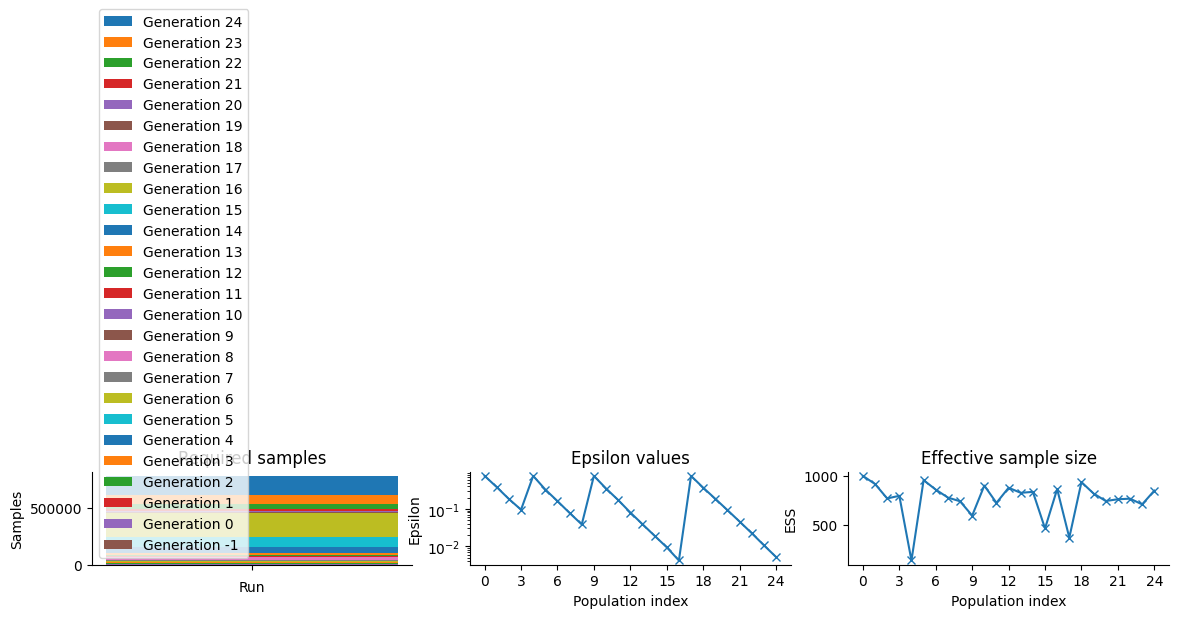

In [92]:
fig, arr_ax = plt.subplots(1, 3, figsize=(12, 4))

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[1])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[2])



That's it. Now you can go ahead and try more sophisticated models.